# Query a spatial mosaic from the Google Earth Engine

* **Last Modified**: 3-12-2024
* **Author**: Gonzalo Mateo-García
---

This tutorial shows how to use the `georeaders.readers.ee_image` module to download an spatial composite with Sentinel-2 or Landsat. 

In [1]:
from shapely.geometry import shape, mapping
from datetime import datetime, timedelta
import ee

ee.Authenticate()
ee.Initialize(project="marsml")

footprint = shape({'type': 'Polygon',
 'coordinates': (((58.21132510761841, 40.391771861041725),
   (58.205632677871314, 40.07155762141618),
   (58.649475248490724, 40.06608738064447),
   (58.65726127535553, 40.38623968067468),
   (58.21132510761841, 40.391771861041725)),)})

date_search = datetime.fromisoformat("2024-10-09T06:54:26+00:00")
date_search

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


datetime.datetime(2024, 10, 9, 6, 54, 26, tzinfo=datetime.timezone.utc)

Earth Engine code adapted from [This blog post](https://medium.com/google-earth/all-clear-with-cloud-score-bd6ee2e2235e).

In [9]:
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')


ROI = ee.Geometry(mapping(footprint))
# ROI = ee.Geometry.Point(-119.9087, 37.4159)

QA_BAND = 'cs'
CLEAR_THRESHOLD = 0.60

date_search_min = date_search - timedelta(days=30)
date_search_max = date_search + timedelta(days=30)
composite = s2.filterBounds(ROI)\
    .filterDate(date_search_min.strftime('%Y-%m-%d'), date_search_max.strftime('%Y-%m-%d'))\
    .linkCollection(csPlus, [QA_BAND])\
    .map(lambda img: img.updateMask(img.select(QA_BAND).gte(CLEAR_THRESHOLD)))\
    .median()

composite

In [10]:
from georeader import get_utm_epsg
from georeader import window_utils

crs_utm = get_utm_epsg(footprint)
footprint_utm = window_utils.polygon_to_crs(footprint, "EPSG:4326", crs_utm)

transform = window_utils.figure_out_transform(bounds=footprint_utm.bounds, resolution_dst=30)
transform

Affine(30.0, 0.0, 602806.2544585154,
       0.0, -30.0, 4471945.817948307)

In [11]:
%%time
from georeader.readers import ee_image
import numpy as np

mosaic = ee_image.export_image(composite, footprint, transform=transform, crs=crs_utm, 
                               bands_gee=["B4","B3","B2"])
mosaic

CPU times: user 473 ms, sys: 50.6 ms, total: 523 ms
Wall time: 1min 8s


 
         Transform: | 30.00, 0.00, 602806.25|
| 0.00,-30.00, 4471945.82|
| 0.00, 0.00, 1.00|
         Shape: (3, 1186, 1263)
         Resolution: (30.0, 30.0)
         Bounds: (602806.2544585154, 4436365.817948307, 640696.2544585154, 4471945.817948307)
         CRS: EPSG:32640
         fill_value_default: None
        

<Axes: >

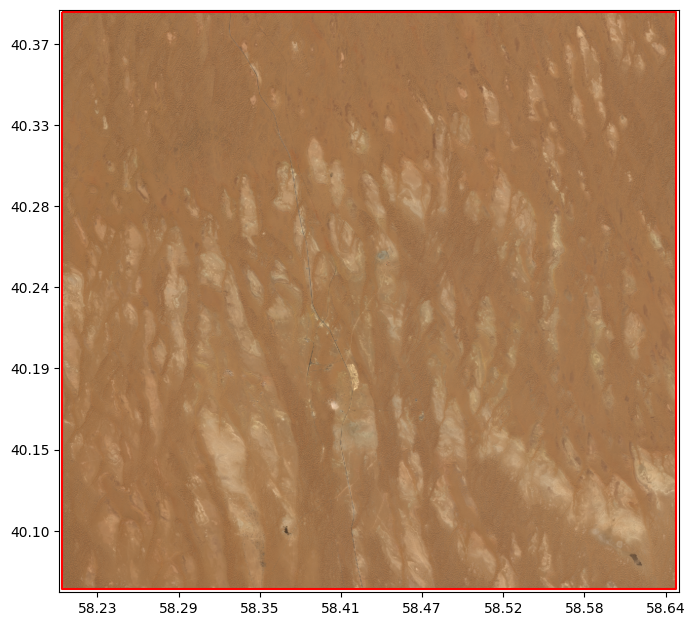

In [14]:
from georeader import plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(8,8))

mosaic = mosaic.pad({"x": (5,5), "y": (5,5)})
mosaic_rgb = (mosaic / 5_500).clip(0,1)
plot.show(mosaic_rgb, ax=ax)

plot.add_shape_to_plot(footprint, ax=ax, crs_plot=mosaic_rgb.crs, polygon_no_fill=True, crs_shape="EPSG:4326",
                       kwargs_geopandas_plot={"color":"red"})

### Composite for Landsat-8 and 9

Earth Engine code adapted from [This blog post](https://medium.com/@nst11/annual-landsat-cloud-free-composite-in-google-earth-engine-c623b69749f7).

In [19]:
# https://medium.com/@nst11/annual-landsat-cloud-free-composite-in-google-earth-engine-c623b69749f7
def maskL8KH(image):
  # Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = (1 << 3)
  cloudsBitMask = (1 << 5)
  # Get the pixel QA band.
  qa = image.select('QA_PIXEL')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  return image.updateMask(mask)

cols = ["LANDSAT/LC09/C02/T1_TOA", "LANDSAT/LC08/C02/T1_RT_TOA", "LANDSAT/LC08/C02/T2_TOA","LANDSAT/LC09/C02/T2_TOA"]
l89col = ee.ImageCollection(cols[0])
for c in cols[1:]:
    l89col.merge(ee.ImageCollection(c))


ROI = ee.Geometry(mapping(footprint))
# ROI = ee.Geometry.Point(-119.9087, 37.4159)

date_search_min = date_search - timedelta(days=30)
date_search_max = date_search + timedelta(days=30)
composite_l8 = l89col.filterBounds(ROI)\
    .filterDate(date_search_min.strftime('%Y-%m-%d'), date_search_max.strftime('%Y-%m-%d'))\
    .map(lambda img: maskL8KH(img))\
    .median()

composite_l8

In [20]:
%%time
mosaic_l8 = ee_image.export_image(composite, footprint, transform=transform, crs=crs_utm, 
                                  bands_gee=["B4","B3","B2"])
mosaic_l8

 
         Transform: | 30.00, 0.00, 602806.25|
| 0.00,-30.00, 4471945.82|
| 0.00, 0.00, 1.00|
         Shape: (3, 1186, 1263)
         Resolution: (30.0, 30.0)
         Bounds: (602806.2544585154, 4436365.817948307, 640696.2544585154, 4471945.817948307)
         CRS: EPSG:32640
         fill_value_default: None
        

<Axes: >

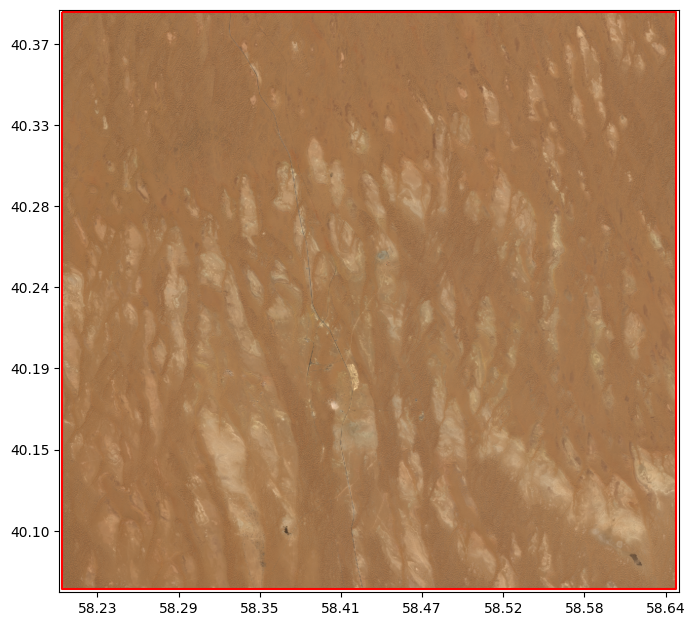

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

mosaic_l8 = mosaic_l8.pad({"x": (5,5), "y": (5,5)})
mosaic_l8_rgb = (mosaic_l8 / 5_500).clip(0,1)
plot.show(mosaic_l8_rgb, ax=ax)

plot.add_shape_to_plot(footprint, ax=ax, crs_plot=mosaic_l8_rgb.crs, polygon_no_fill=True, crs_shape="EPSG:4326",
                       kwargs_geopandas_plot={"color":"red"})